### Libraries

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf

import numpy as np
from numpy import trace
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.datasets import fashion_mnist
from keras.datasets import mnist
import keras.backend as K
from keras.layers import Input, Dense, Lambda
from keras.layers import Flatten, Reshape
from keras.layers import BatchNormalization, Dropout, ReLU, Reshape
from PIL import Image as im
from numpy import cov
from numpy import asarray
from skimage.transform import resize
from itertools import chain
import random
from tensorflow.keras.optimizers import Adam

### Normalizing the training set

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

for i in range(32):
    x_train = np.insert(x_train, len(x_train)-1, x_test[i], axis = 0)

x_train = x_train / 255

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
for i in range(32):
    y_train = np.insert(y_train, len(y_train)-1, y_test[i], axis = 0)


In [ ]:
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))

In [ ]:
print(x_train.shape)

(60032, 28, 28, 1)


If the error message "You are passing KerasTensor ..." appeared, recompile the 2 cells prior to the training section and then retrain the model.

In [ ]:
from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()
######################################### If you are facing more errors

In [ ]:
# import tensorflow._api.v2.compat.v1 as tf_dis

# tf_dis.disable_v2_behavior()

### VAE components and methods

In [ ]:
batch_size = 128
hidden_dim = 2 # Since we are in 2D space (images), the dimensions of mean and var are 2
n_epochs = 60

def dropout_and_batchnorm(x):
    return Dropout(0.3)(BatchNormalization()(x))

def prior(args):
    mean, log_var, batch_size, hidden_dim = args
    N = K.random_normal(shape=(batch_size, hidden_dim), mean=0., stddev=1.0)
    return K.exp(log_var / 2) * N + mean

In [ ]:
class VAE:
    def __init__(self, batch_size_, hidden_dim_, epochs_):
        self.batch_size = batch_size_
        self.hidden_dim = hidden_dim_
        self.epochs = epochs_
        self.input_image = Input(batch_shape=(self.batch_size, 28, 28, 1))
        self.encoder, self.latent_space = self.build_the_encoder()
        self.decoder = self.build_the_decoder()

    def build_the_encoder(self):
        x = Flatten()(self.input_image)
        x = Dense(256, activation="relu")(x)
        x = dropout_and_batchnorm(x)
        x = Dense(128, activation="relu")(x)
        x = dropout_and_batchnorm(x)
        self.mean = Dense(self.hidden_dim)(x)
        self.log_var = Dense(self.hidden_dim)(x)
        latent_space = Lambda(prior, output_shape=(self.hidden_dim))([self.mean, self.log_var, self.batch_size, self.hidden_dim])
        encoder = keras.Model(self.input_image, latent_space)
        return encoder, latent_space

    def build_the_decoder(self):
        input_decoder = Input(shape=(self.hidden_dim,))
        d = Dense(128, activation="relu")(input_decoder)
        d = dropout_and_batchnorm(d)
        d = Dense(256, activation="relu")(d)
        d = dropout_and_batchnorm(d)
        d = Dense(28*28, activation="sigmoid")(d)
        # The final layer
        decoded_image = Reshape((28, 28, 1))(d)
        decoder = keras.Model(input_decoder, decoded_image)
        return decoder


    # def build_the_decoder(self):
    #     dec = tf.keras.Sequential()
    #     dec.add(Dense(128, input_shape = (2,)))
    #     dec.add(ReLU())
    #     dec.add(Dropout(0.3))
    #     dec.add(BatchNormalization())
    #     dec.add(Dense(256))
    #     dec.add(ReLU())
    #     dec.add(Dropout(0.3))
    #     dec.add(BatchNormalization())
    #     dec.add(Dense(28*28, activation = "sigmoid"))
    #     dec.add(Reshape((28, 28, 1)))
    #     return dec

    def loss(self, main, reconstructed):
        main = K.reshape(main, shape=(self.batch_size, 28*28))
        reconstructed = K.reshape(reconstructed, shape=(self.batch_size, 28*28))
        reconstruction_loss = K.sum(K.square(main-reconstructed), axis=-1)
        kl_loss = -0.5 * K.sum(1 + self.log_var - K.square(self.mean) - K.exp(self.log_var), axis=-1)
        return reconstruction_loss + kl_loss

In [ ]:
vae = VAE(batch_size, hidden_dim, n_epochs)

Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
latent_sp = vae.encoder(vae.input_image)
model = keras.Model(vae.input_image, vae.decoder(latent_sp))
model.compile(optimizer= "adam", loss=vae.loss)

In [ ]:
vae.encoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(128, 28, 28, 1)]           0         []                            
                                                                                                  
 flatten (Flatten)           (128, 784)                   0         ['input_1[0][0]']             
                                                                                                  
 dense (Dense)               (128, 256)                   200960    ['flatten[0][0]']             
                                                                                                  
 batch_normalization (Batch  (128, 256)                   1024      ['dense[0][0]']               
 Normalization)                                                                               

In [ ]:
vae.decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_4 (Dense)             multiple                  384       
                                                                 
 batch_normalization_2 (Bat  multiple                  512       
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         multiple                  0         
                                                                 
 dense_5 (Dense)             multiple                  33024     
                                                                 
 batch_normalization_3 (Bat  multiple                  1024      
 chNormalization)                                          

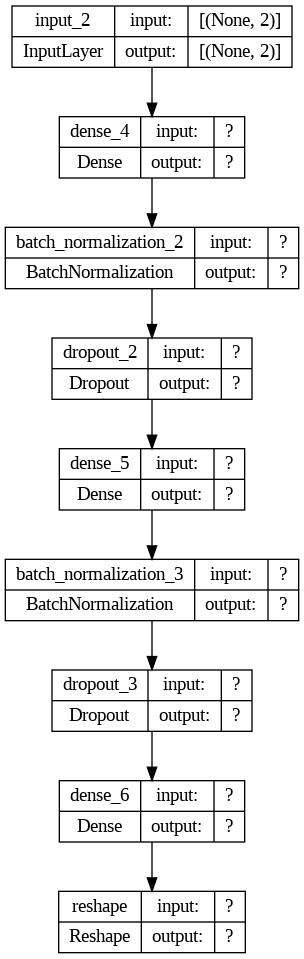

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(vae.decoder, to_file='decoder.png', show_shapes=True, show_layer_names=True)

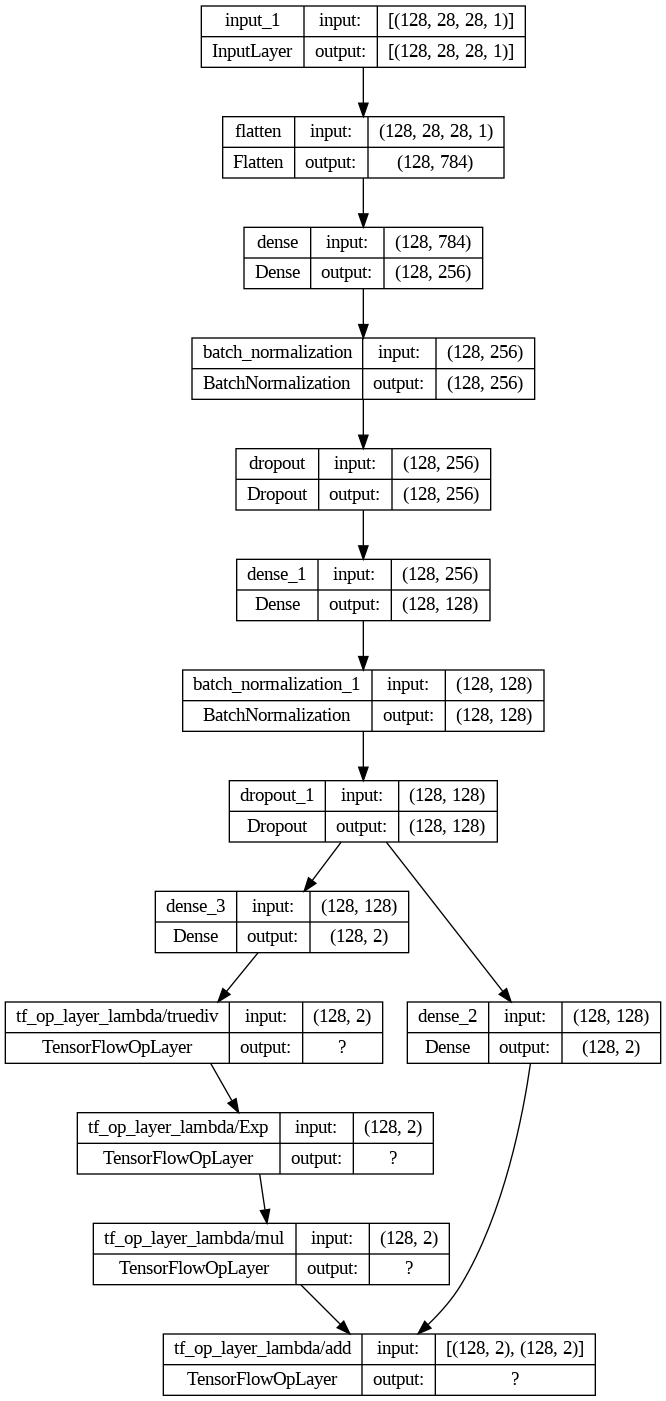

In [ ]:
plot_model(vae.encoder, to_file='encoder.png', show_shapes=True, show_layer_names=True)

### Training the VAE
(Trained with A100 Because of the Calc_FID problem)

In [ ]:
import time
start_time = time.time()
model.fit(x_train, x_train, epochs=vae.epochs, batch_size = vae.batch_size, shuffle=True)
end_time = time.time()
exe_time = end_time - start_time

Train on 60032 samples
Epoch 1/60
60032/60032 [==============================] - 10s 166us/sample - loss: 86.8831
Epoch 2/60
60032/60032 [==============================] - 4s 63us/sample - loss: 50.5775
Epoch 3/60
60032/60032 [==============================] - 4s 59us/sample - loss: 47.5317
Epoch 4/60
60032/60032 [==============================] - 6s 103us/sample - loss: 45.7302
Epoch 5/60
60032/60032 [==============================] - 6s 107us/sample - loss: 44.5655
Epoch 6/60
60032/60032 [==============================] - 7s 110us/sample - loss: 43.7499
Epoch 7/60
60032/60032 [==============================] - 4s 75us/sample - loss: 43.2242
Epoch 8/60
60032/60032 [==============================] - 5s 80us/sample - loss: 42.8491
Epoch 9/60
60032/60032 [==============================] - 5s 81us/sample - loss: 42.5823
Epoch 10/60
60032/60032 [==============================] - 3s 58us/sample - loss: 42.3251
Epoch 11/60
60032/60032 [==============================] - 4s 59us/sample - loss:

In [ ]:
## MNIST exceptionally
print("Exec Time: ", exe_time)

Exec Time:  245.86877751350403


### Sampling from the Latent

In [ ]:
def sample_from(number_of_samples, interval, seed):
    random.seed(seed)
    points = [random.randrange(interval[0], interval[1]) for _ in range(2*number_of_samples)]
    samples = []
    for i in range(0, 2*number_of_samples, 2):
        samples.append([points[i], points[i+1]])
    return samples

In [ ]:
import math

def plot_distribution(vae, points, save, show, series):
    n =  int(math.sqrt(len(points)))
    size = 2*n
    num = 1
    if show:
        plt.figure(figsize=(size, size))
    start = time.time()
    for i in range(-n, n+1):
        for j in range(-n, n+1):
            if(num > len(points)): continue
            image = vae.decoder.predict(np.expand_dims(points[num-1], axis=0))
            # global fid_score_list
            # if len(fid_score_list) == 0:
            #   fid_score_list = image
            # elif len(fid_score_list) > 0:
            #   fid_score_list = np.append(fid_score_list, image, axis = 0)
            # if save:
            #     plt.figure(figsize=(size/2, size/2))
            #     image_name = path_to_save + '/'+str(vae.epochs)+"_"+str(vae.batch_size)+"_label_"+str(num - 1)+"_"+ str(series) +".png"
            #     plt.imshow(image.squeeze(), cmap="gray")
            #     plt.savefig(image_name)
            #     plt.close()
            if show:
                ax = plt.subplot(size, size, num)
                plt.imshow(image.squeeze(), cmap="gray")
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
                # plt.show()
                # plt.close() # If the images were not shown, comment this line
                num += 1

    end = time.time()
    exe_time = end - start
    if save == False:
        return exe_time

In [ ]:
def sample_from_latent(num_sqrt, score_list):
    size = 2*num_sqrt + 1
    num = 1
    # plt.figure(figsize=(size * 1.5, size * 1.5))
    for i in range(-num_sqrt, num_sqrt + 1):
        for j in range(-num_sqrt, num_sqrt + 1):
            # ax = plt.subplot(size, size, num)
            num += 1
            image = vae.decoder.predict(np.expand_dims([3*i/num_sqrt, 3*j/num_sqrt], axis=0))
            score_list.append(image[0])
            # plt.imshow(image.squeeze(), cmap="gray")
            # plt.title(str(i) + "&&" + str(j))
            # ax.get_xaxis().set_visible(False)
            # ax.get_yaxis().set_visible(False)
    return score_list

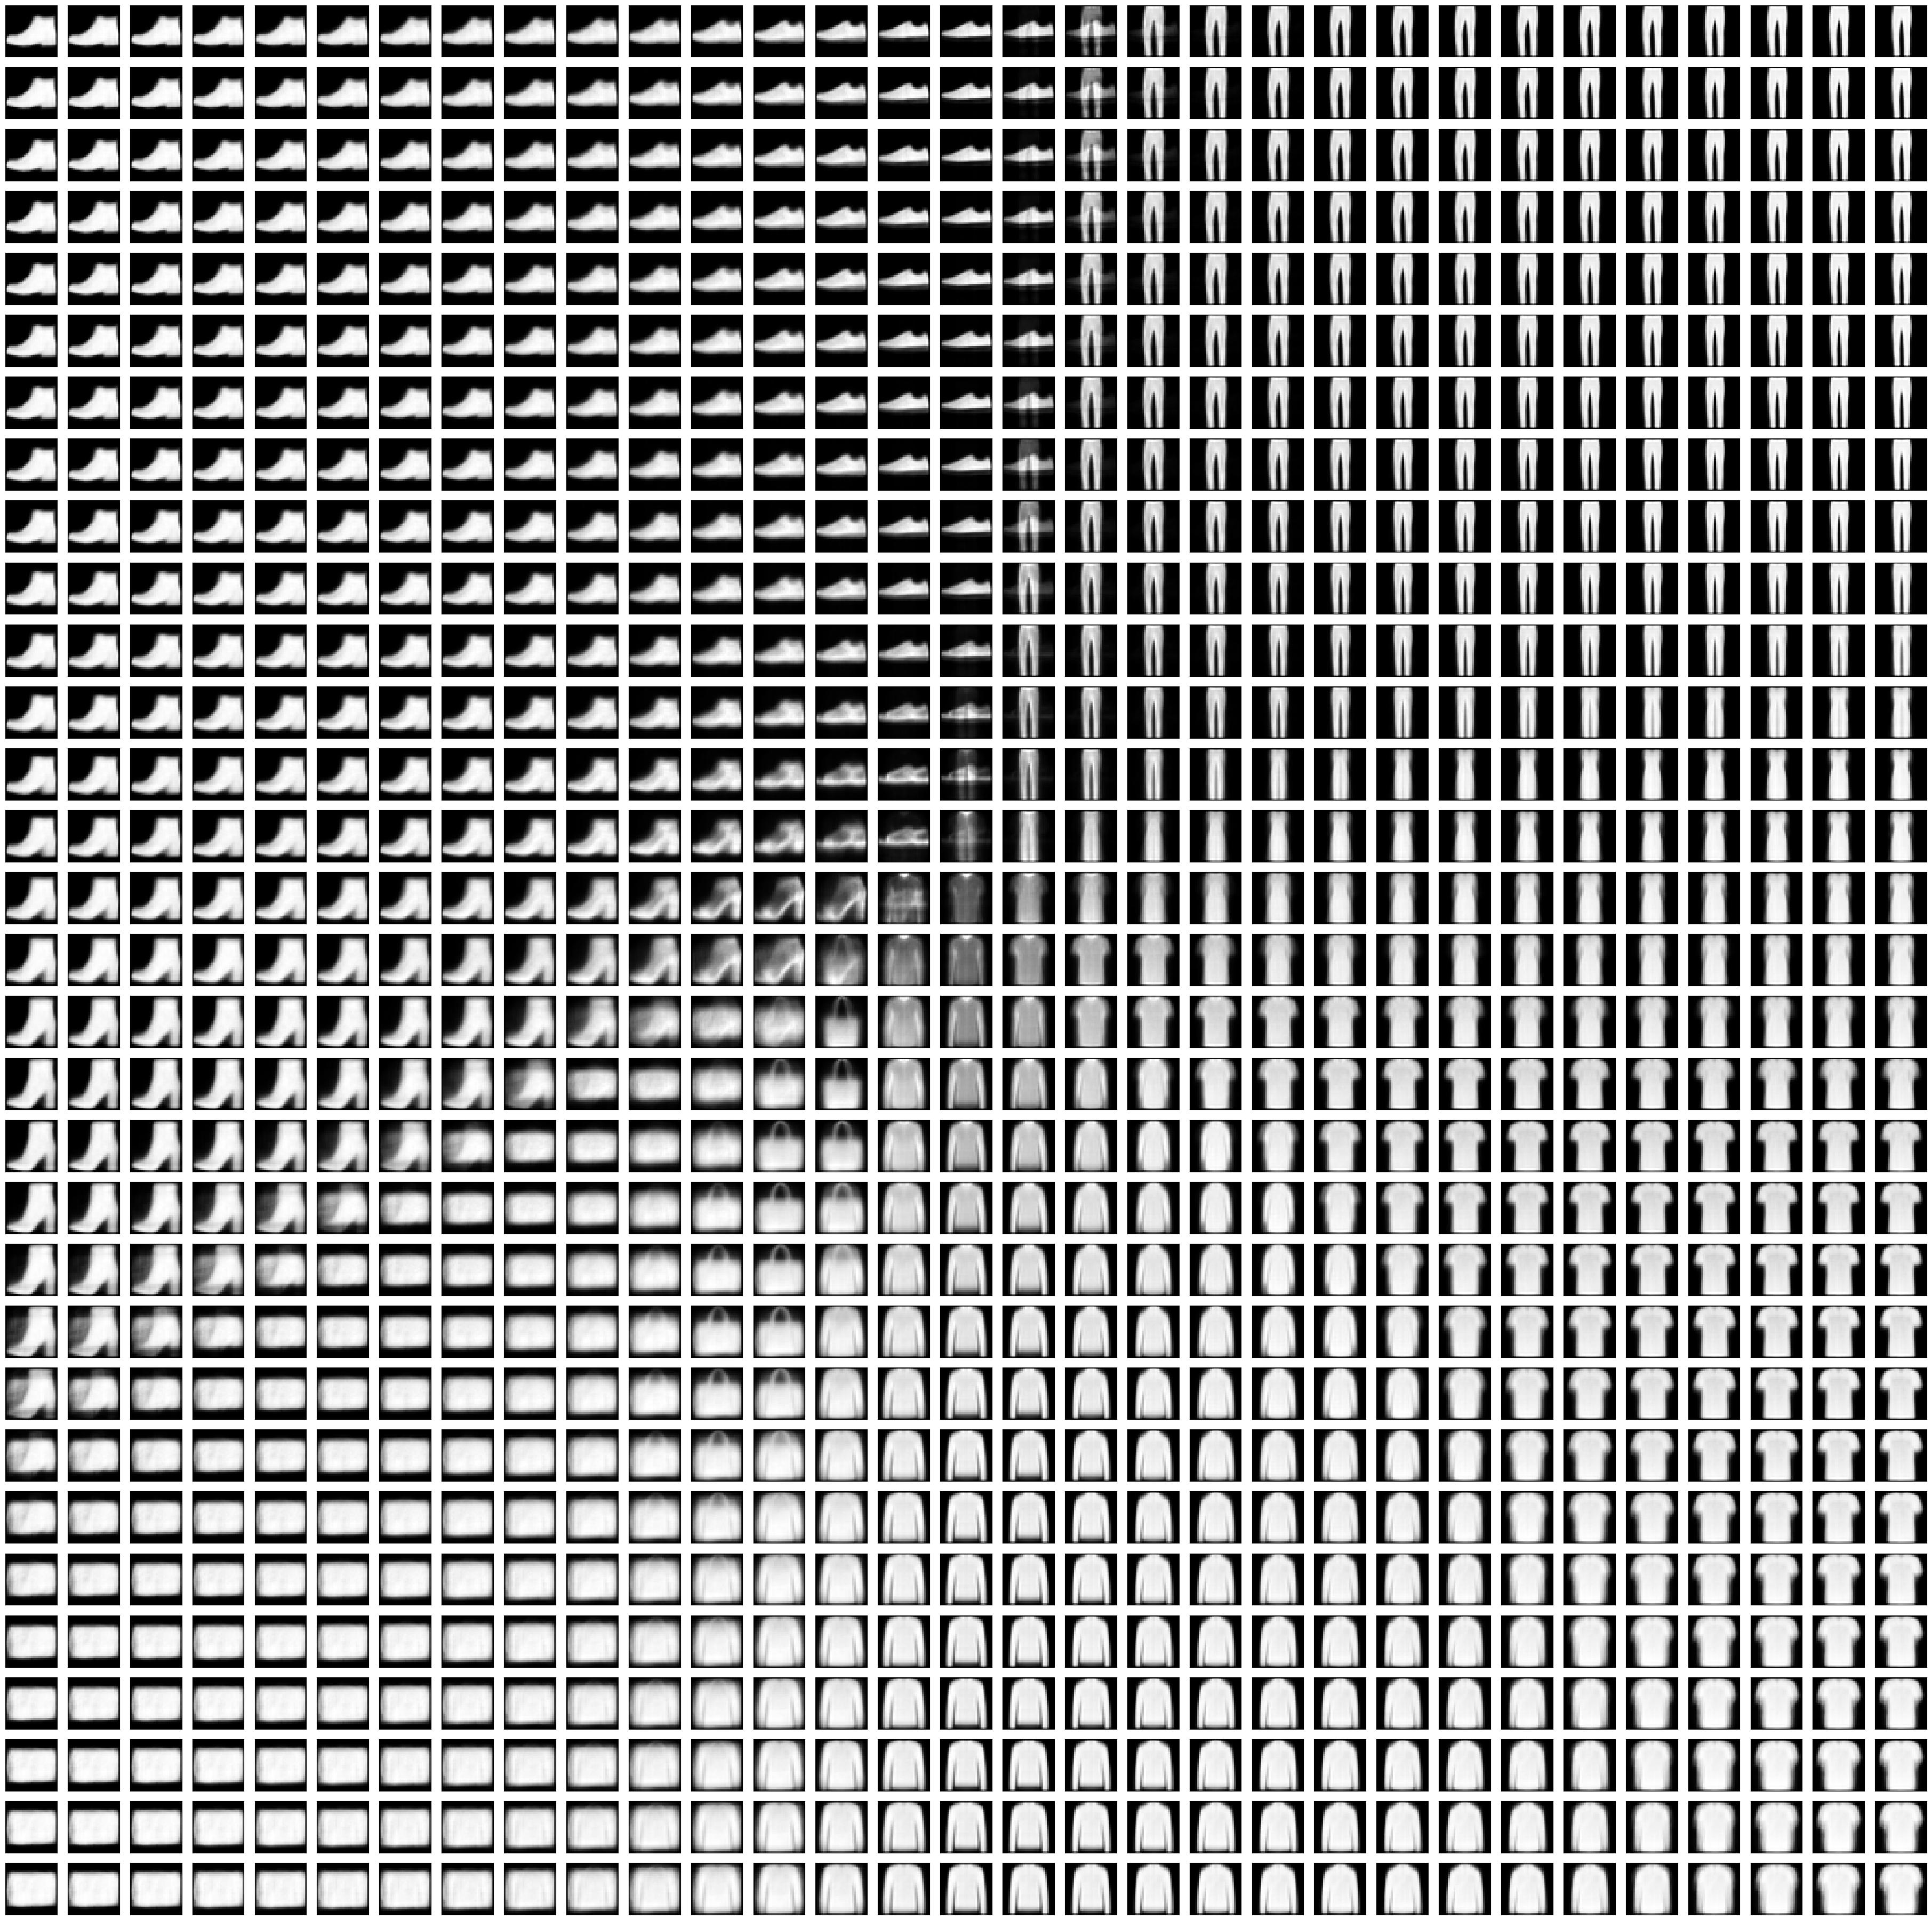

In [ ]:
_ = sample_from_latent(num_sqrt = 15, score_list = [])

### Generating Samples

In [ ]:
number_of_samples = 16
infinity_interval = [int(-1e6), int(1e6)]
bad_samples = sample_from(number_of_samples, infinity_interval, seed = 0)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


1.42149019241333

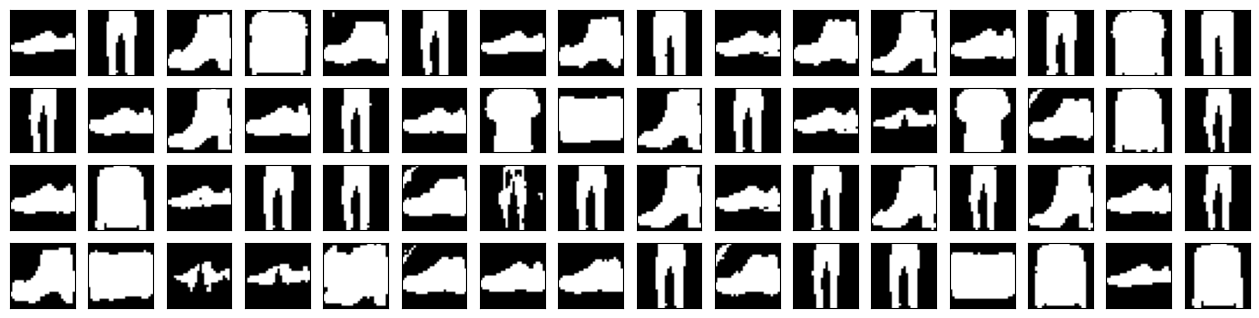

In [ ]:
plot_distribution(vae, bad_samples, False, True, series = 0) # If the images were not shown, comment this line

1.2493095397949219

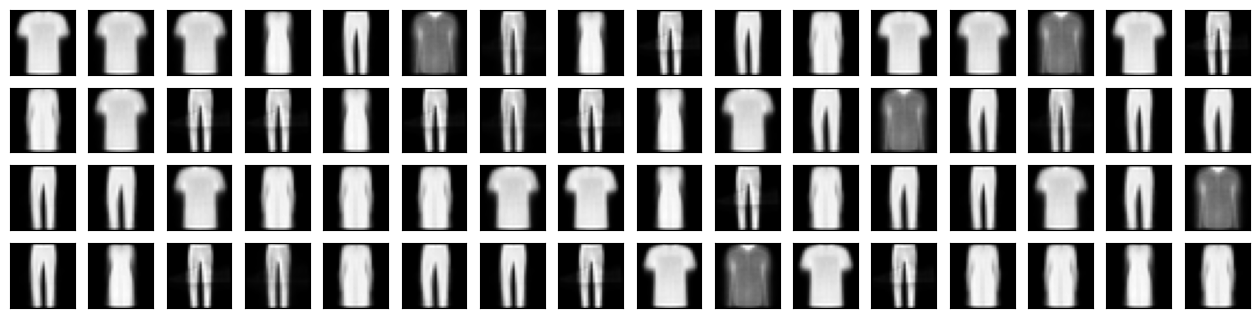

In [ ]:
good_interval = [0, 3]
better_samples = sample_from(number_of_samples, good_interval, seed = 1)
plot_distribution(vae, better_samples, False, True, series = 1)

1.326930046081543

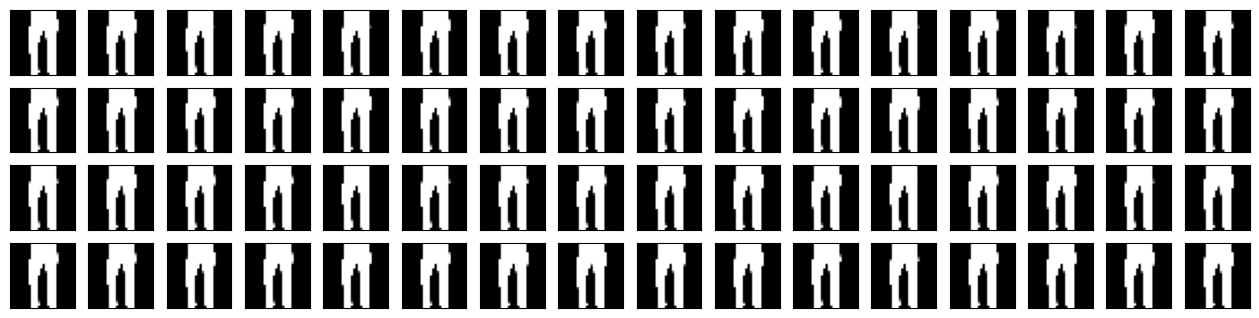

In [ ]:
interval = [80, 100]
better_samples = sample_from(number_of_samples, interval, seed = 20)
plot_distribution(vae, better_samples, False, True, series = 20)

1.3135688304901123

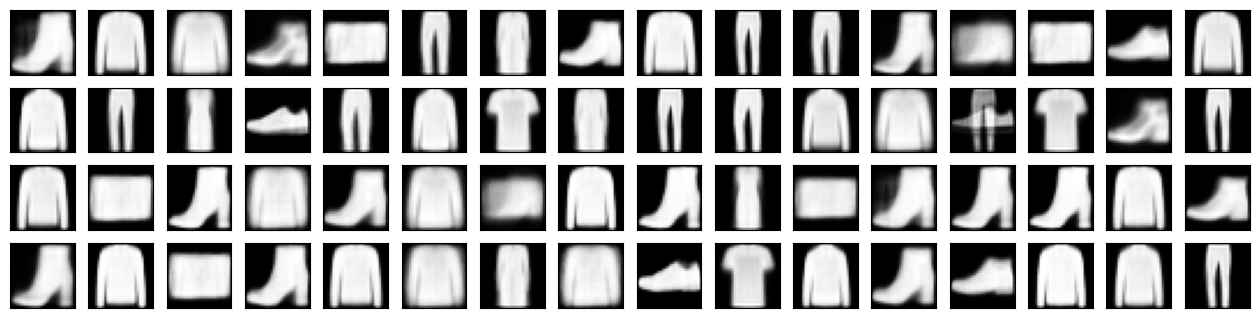

In [ ]:
samples = sample_from(number_of_samples, [-4, 4], seed = 2)
plot_distribution(vae, samples, False, True, series = 2)

1.3342714309692383

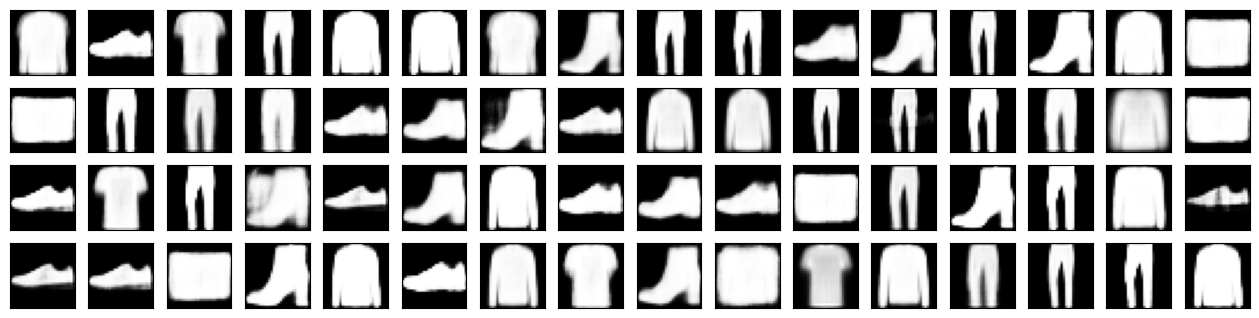

In [ ]:
samples = sample_from(number_of_samples, [-10, 10], seed = 3)
plot_distribution(vae, samples, False, True, series = 3)

### Inference Time

In [ ]:
def scatter(first_axis, second_axis, title):
    # plt.figure(figsize=(10, 8))
    plt.title(title)
    plt.scatter(first_axis, second_axis, marker = '.')

In [ ]:
inference_times = []
number_of_runs = 100

In [ ]:
print(number_of_samples)
print(len(inference_times))

16
100


In [ ]:
seed = 10
seri = 10
for i in range(number_of_runs):
    thresh = 1e6
    samples = sample_from(number_of_samples, [-thresh, thresh], seed)
    inf_time = plot_distribution(vae, samples, False, False, series = seri)
    seed += 1
    seri += 1
    inference_times.append(inf_time)

<ipython-input-15-77858dbe9660>:3: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  points = [random.randrange(interval[0], interval[1]) for _ in range(2*number_of_samples)]


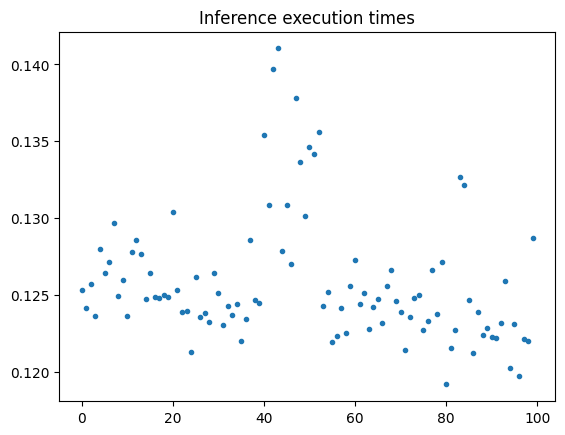

In [ ]:
scatter(np.arange(0,len(inference_times)), inference_times, "Inference execution times")

In [ ]:
print("Mean inference time: ", round(sum(inference_times)/len(inference_times), 4))

Mean inference time:  0.1258


### FID Score with Inception V3

In [ ]:
fid_score_list = []

In [ ]:
fid_score_list = sample_from_latent(num_sqrt = 49, score_list = fid_score_list)

In [ ]:
fid_score_list = np.asarray(fid_score_list)
print(fid_score_list.shape)
print(x_train.shape)

(9801, 28, 28, 1)
(60032, 28, 28, 1)


In [ ]:
import gc

gc.collect()

0

In [ ]:
from fid00 import FID_measure
import random
import gc

In [ ]:
gc.collect()

0

In [ ]:
fid = FID_measure(gen_images_ = fid_score_list, train_set_ = x_train, labels_ = y_train)
train_set_shrinked, train_set_shrinked_labels = fid.sample_uniformly(num_sample_per_class = int(len(fid_score_list)/10))

Train set len :  60032
Middle of sample uniformly
Train set len :  9800
End of sample uniformly


In [ ]:
print(len(fid_score_list))

9801


In [ ]:
score = fid.calculate_fid()
print('FID: %.3f' % score)

train_images before preprocess:  (9800, 28, 28, 1)
gen images before preprocess:  (9801, 28, 28, 1)
train_images after scale:  (9800, 299, 299, 3)
gen images after scale:  (9801, 299, 299, 3)
train_images after preprocess:  (9800, 299, 299, 3)
gen images after preprocess:  (9801, 299, 299, 3)
87910968/87910968 [==============================] - 5s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Inception-V3 output for gen images:  (9801, 2048)
Inception-V3 output for train images:  (9800, 2048)
Mu1 shape:  (2048,)
Sigma1 shape:  (2048, 2048)
Mu2 shape:  (2048,)
Sigma2 shape:  (2048, 2048)
FID: 7.679


### Mean and Covariance Matrix of Train and Generated Images

In [ ]:
def calc_mu_and_sigma(dataset):
    # The returned sigma is the covariance matrix and mu is the mean
    flatten_images = []

    for i in range(len(dataset)):
        vectorize = np.array(list(chain.from_iterable(dataset[i])))
        flatten_images.append(vectorize)

    flatten_images = np.array(flatten_images)
    print("Flatten images: ", flatten_images.shape)
    mu = flatten_images.mean(axis = 0)
    print("Mu: ", mu.shape)
    sigma = np.dot(flatten_images[0], flatten_images[0].T)

    print("Sigma: ", sigma.shape)

    for i in range(1, len(flatten_images)):
        Ui = np.dot(flatten_images[i], flatten_images[i].T)
        sigma += Ui

    mu_mu_T = np.dot(mu, mu.T)
    sigma = sigma / len(dataset)
    sigma = sigma - mu_mu_T

    return mu, sigma, flatten_images

In [ ]:
mu_train, sigma_train, vectorized_train = calc_mu_and_sigma(train_set_shrinked)

Flatten images:  (9800, 784, 1)
Mu:  (784, 1)
Sigma:  (784, 784)


In [ ]:
mu_gen, sigma_gen, vectorized_gen = calc_mu_and_sigma(fid_score_list)

Flatten images:  (9801, 784, 1)
Mu:  (784, 1)
Sigma:  (784, 784)


### CNN for Predicting Generated Images

In [ ]:
label_names = np.array(['T-shirt/top', 'Trousers', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'])

In [ ]:
from keras.models import load_model
cnn = load_model('CNN_fashion.h5')

In [ ]:
preds_gen = cnn.predict(fid_score_list)
pred_labels_gen = np.argmax(preds_gen, axis=1)

In [ ]:
unique_elements, counts = np.unique(label_names[pred_labels_gen], return_counts=True)
frequency = dict(zip(unique_elements, counts))
print("Frequency of Elements: ")
print(frequency)

Frequency of Elements: 
{'Ankle boot': 140, 'Bag': 4748, 'Dress': 1199, 'Pullover': 282, 'Sandal': 1024, 'Shirt': 536, 'Sneaker': 336, 'T-shirt/top': 779, 'Trousers': 757}


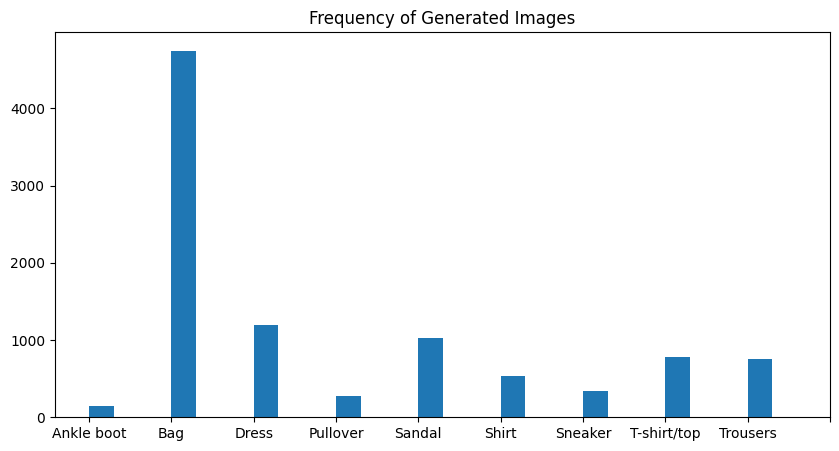

In [ ]:
plt.figure(figsize=(10, 5))
plt.bar(unique_elements, counts, align='edge', width=0.3)
plt.xticks(np.arange(10))
plt.title('Frequency of Generated Images')
plt.show()

In [ ]:
unique_elements, counts = np.unique(pred_labels_gen, return_counts=True)
frequency = dict(zip(unique_elements, counts))
print("Frequency of Elements: ")
print(frequency)

Frequency of Elements: 
{0: 779, 1: 757, 2: 282, 3: 1199, 5: 1024, 6: 536, 7: 336, 8: 4748, 9: 140}


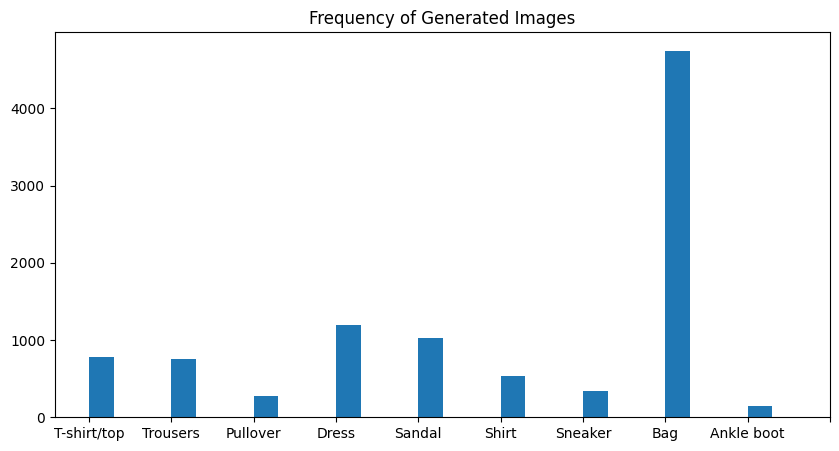

In [ ]:
plt.figure(figsize=(10, 5))
plt.bar(label_names[unique_elements], counts, align='edge', width=0.3)
plt.xticks(np.arange(10))
plt.title('Frequency of Generated Images')
plt.show()

### Viewing Dimension-Reduced Generated Samples

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
def scatter(first_axis, second_axis, labels, title):
    plt.figure(figsize=(10, 8))
    unique_classes = set(labels)
    plt.title(title)
    colors = ["red", "green", "blue", "yellow", "pink", "black", "orange", "purple", "cyan", "magenta"]
    for i, class_label in enumerate(unique_classes):
        class_indices = [j for j, c in enumerate(labels) if c == class_label]
        plt.scatter([first_axis[idx] for idx in class_indices],
                    [second_axis[idx] for idx in class_indices],
                    color=colors[i % len(colors)],
                    label=f'Class {class_label}')

    plt.legend()
    plt.show()


def map_diversity(data, variance_PCA):
    if data.ndim == 3:
        data = data.squeeze()
    pca = PCA(n_components = variance_PCA)
    reduced_vectors_pca = pca.fit_transform(data)
    # print(pca.n_components_) # If interested
    tsne = TSNE(n_components=2)
    reduced_vectors_tsne = tsne.fit_transform(reduced_vectors_pca)
    return reduced_vectors_tsne

In [ ]:
reduced_dimension_gen = map_diversity(data = vectorized_gen, variance_PCA = 0.85)

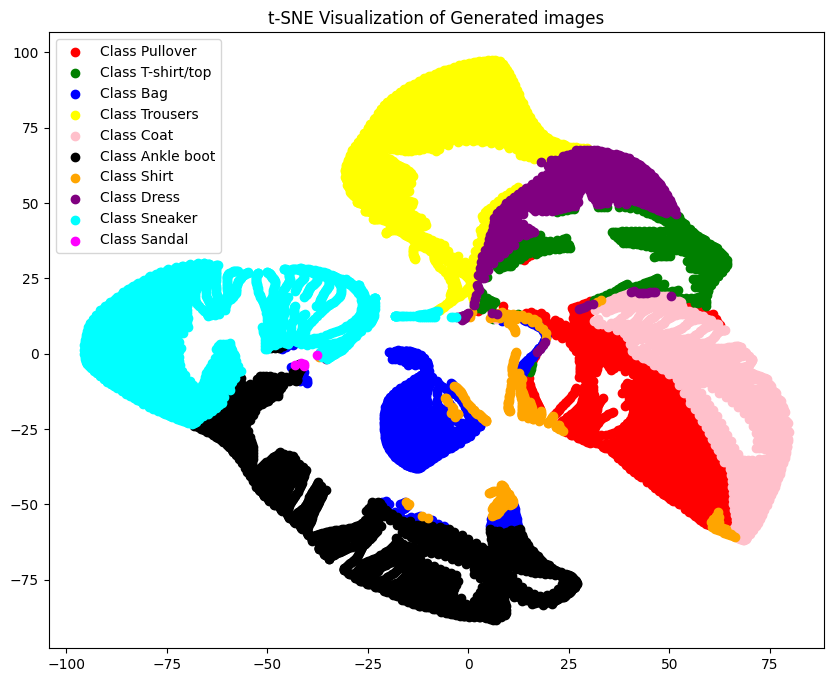

In [ ]:
scatter(reduced_dimension_gen[:, 0], reduced_dimension_gen[:, 1], label_names[pred_labels_gen], 't-SNE Visualization of Generated images')

In [ ]:
reduced_dimension_train = map_diversity(data = vectorized_train, variance_PCA = 0.85)

In [ ]:
# scatter(reduced_dimension_train[:, 0], reduced_dimension_train[:, 1], y_train, 't-SNE Visualization of the Train Set')

### Density, Coverage, Recall, Precision Parameters

In [ ]:
print(reduced_dimension_train.shape)
print(reduced_dimension_gen.shape)

(9800, 2)
(9801, 2)


In [ ]:
gc.collect()

0

In [ ]:
!pip3 install prdc

from prdc import compute_prdc

In [ ]:
# _, _, vectorized_train_shrinked = calc_mu_and_sigma(train_set_shrinked)
# reduced_dimension_train_shrinked = map_diversity(data = vectorized_train_shrinked, variance_PCA = 0.85)

In [ ]:
for j in np.asarray([5, 10, 6, 3, 2, 1]):
    print(j, "-Nearest Neighbors")
    metrics = compute_prdc(real_features = reduced_dimension_train,
                          fake_features = reduced_dimension_gen[:9800],
                          nearest_k=j)

    print(metrics)
    print("\n----------------------------------\n")

5 -Nearest Neighbors
Num real: 9800 Num fake: 9800
{'precision': 0.5253061224489796, 'recall': 0.5409183673469388, 'density': 0.4429183673469388, 'coverage': 0.49142857142857144}

----------------------------------

10 -Nearest Neighbors
Num real: 9800 Num fake: 9800
{'precision': 0.5820408163265306, 'recall': 0.6078571428571429, 'density': 0.4667040816326531, 'coverage': 0.5706122448979591}

----------------------------------

6 -Nearest Neighbors
Num real: 9800 Num fake: 9800
{'precision': 0.539795918367347, 'recall': 0.5616326530612245, 'density': 0.44727891156462585, 'coverage': 0.5166326530612245}

----------------------------------

3 -Nearest Neighbors
Num real: 9800 Num fake: 9800
{'precision': 0.46724489795918367, 'recall': 0.48918367346938774, 'density': 0.4072108843537415, 'coverage': 0.39785714285714285}

----------------------------------

2 -Nearest Neighbors
Num real: 9800 Num fake: 9800
{'precision': 0.3970408163265306, 'recall': 0.4223469387755102, 'density': 0.3654591